Speed limit recognition software

In [110]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#necessary imports

In [111]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
seed = 123 
dataset = 'data'
train_data = image_dataset_from_directory(
    dataset,
    image_size=(128, 128),
    batch_size=6,
    label_mode='int',
    shuffle=True,
    validation_split=0.25,
    subset="training",
    seed=seed
)
validation_data = image_dataset_from_directory(
    dataset,
    image_size=(128, 128),
    batch_size=6,
    label_mode='int',
    shuffle=True,
    validation_split=0.25,
    subset="validation", 
    seed=seed 
)
class_names= train_data.class_names


Found 90 files belonging to 9 classes.
Using 68 files for training.
Found 90 files belonging to 9 classes.
Using 22 files for validation.


In [112]:
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

data_aug = tf.keras.Sequential([ #augmentation for a more robust dataset
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])
train_data = train_data.map(
    lambda x, y: (data_aug(x, training=True), y)
)


In [113]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(128,128,3)), #layer1 with l2 regularization due to small dataset
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3), #dropout because of small dataset
    layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(0.01), activation='relu'), #layer2
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l2(0.01), activation='relu'), #layer3
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Flatten(), #3d into 1d
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,801 (12.61 MB)

 Trainable params: 3,305,801 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [131]:
def evaluate_model(data): #this is done so that the model wont trigger tensorflow retracing, which it previously did due to using tf function in a loop.
    return model.evaluate(data, verbose=0)

running_accuracy = 0
running_val_accuracy = 0
iteration = 0

while True:
    fitted = model.fit(
        train_data,
        epochs=10,
        validation_data=validation_data,
    )

    loss, accuracy = evaluate_model(train_data)
    val_loss, val_accuracy = evaluate_model(validation_data)

    iteration += 1
    running_accuracy += accuracy
    running_val_accuracy += val_accuracy
    mean_accuracy = running_accuracy / iteration
    mean_val_accuracy = running_val_accuracy / iteration

    print(f"mean train_data accuracy: {mean_accuracy:.2f}")
    print(f"mean val accuracy: {mean_val_accuracy:.2f}")
    print(f"iteration: {iteration}")

    if mean_accuracy >= 0.70 and mean_val_accuracy >= 0.5:#low value due to very limited dataset 
        print("training done")
        break

    if iteration > 35 and mean_accuracy < 0.70 and mean_val_accuracy < 0.5:
        print("training stopped")
        break


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8996 - loss: 1.2231 - val_accuracy: 0.5455 - val_loss: 4.5914
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8534 - loss: 1.2877 - val_accuracy: 0.5909 - val_loss: 5.7624
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8921 - loss: 1.2411 - val_accuracy: 0.5455 - val_loss: 3.9038
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9676 - loss: 0.9835 - val_accuracy: 0.4091 - val_loss: 3.9105
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9325 - loss: 1.0646 - val_accuracy: 0.5000 - val_loss: 4.7399
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9711 - loss: 1.0367 - val_accuracy: 0.4545 - val_loss: 4.4218
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9532 - loss: 0.9556 - val_accuracy: 0.5455 - val_loss: 4.3100
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9605 - loss: 0.9519 - val_accuracy: 0.5000 

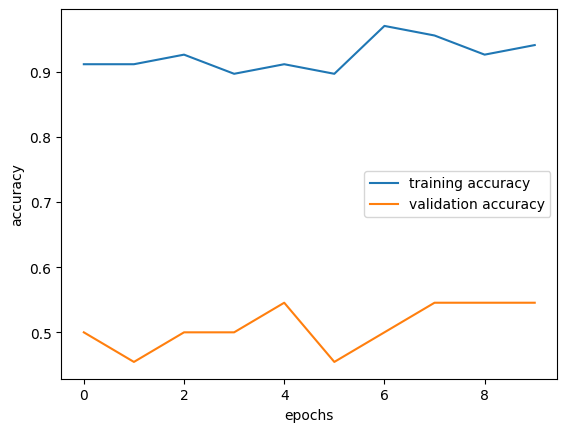

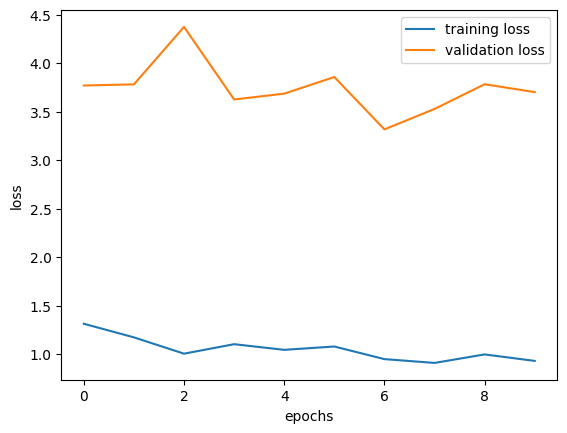

In [132]:
import matplotlib.pyplot as plt 
plt.plot(fitted.history['accuracy'], label='training accuracy') #basic visualization for easy interpretation
plt.plot(fitted.history['val_accuracy'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(fitted.history['loss'], label='training loss')
plt.plot(fitted.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [133]:
model.save('SPEED_LIMIT_MODEL.keras') #save model

In [134]:
from tensorflow.keras.preprocessing import image

img_path = '80KMH.jpg' #image not in dataset so can be used
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0) 

pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]
print(f"Predicted Class: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Class: 80kmh


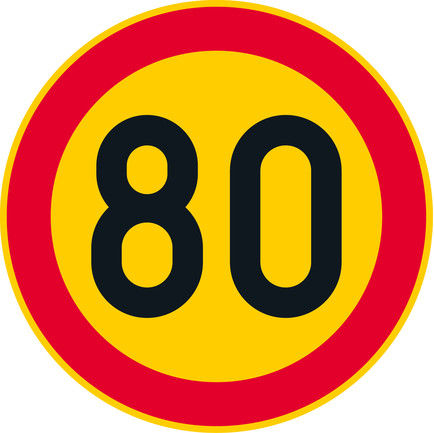

In [135]:
from PIL import Image
from IPython.display import display
#example of the model returning a picture of the speed limit to the user
def speedlim(pred_class):
    if pred_class == '80kmh':
        img80 = 'speeds/80.jpg'
        try:
            image80 = Image.open(img80)
            return image80
        except FileNotFoundError:
            return None
    else:
        return None
        
image = speedlim(pred_class)

if image:
    display(image)  